Bu kodun amacı, NYC taksi bahşiş miktarını tahmin etmek için karar ağaçları kullanarak bir regresyon modeli oluşturmaktır. Gerçek bir veri seti olan 2019 Haziran ayına ait taksi kayıtları kullanılarak, veriler öncelikle temizlenir ve işlenir. Ardından, Scikit-Learn ve Snap ML kütüphaneleri kullanılarak iki farklı karar ağacı regresyon modeli eğitilir. Son olarak, her iki modelin eğitim süresi ve tahmin doğruluğu karşılaştırılır, böylece Snap ML'nin eğitimde sağladığı hız avantajı vurgulanır.

In [11]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import time
import gc


# 1. Veriyi Okuma ve Temizleme


## 1.1. Veriyi Okuma

In [20]:
# Veriyi okuma
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("Datasette " + str(len(raw_data)) + " gözlem var.")
print("Datasette " + str(len(raw_data.columns)) + " değişken var.")


Datasette 3936004 gözlem var.
Datasette 18 değişken var.


## 1.2. Veriyi Temizleme

In [21]:
# İlk 100.000 kaydı kullan
raw_data = raw_data.head(100000)  # Verinin ilk 100.000 kaydını alarak işlemlere başla

# Temizleme işlemleri
raw_data = raw_data[raw_data['tip_amount'] > 0]  # Bahşiş miktarı sıfırdan büyük olanları tut
raw_data = raw_data[raw_data['tip_amount'] <= raw_data['fare_amount']]  # Bahşiş miktarı, ücret miktarını aşmamalı
raw_data = raw_data[(raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200)]  # Ücret miktarı belirli bir aralıkta olmalı
clean_data = raw_data.drop(['total_amount'], axis=1)  # 'total_amount' sütununu çıkararak temiz veri seti oluştur

# Bellek temizliği
del raw_data  # Geçici raw_data değişkenini sil
gc.collect()  # Belleği temizle

# Kalan kayıt sayısını göster
print("Datasette " + str(len(clean_data)) + " gözlem var.")  # Kalan gözlem sayısını yazdır
print("Datasette " + str(len(clean_data.columns)) + " değişken var.")  # Kalan değişken sayısını yazdır


Datasette 65349 gözlem var.
Datasette 17 değişken var.


# 2.Bahşiş Dağılımını Gösterme

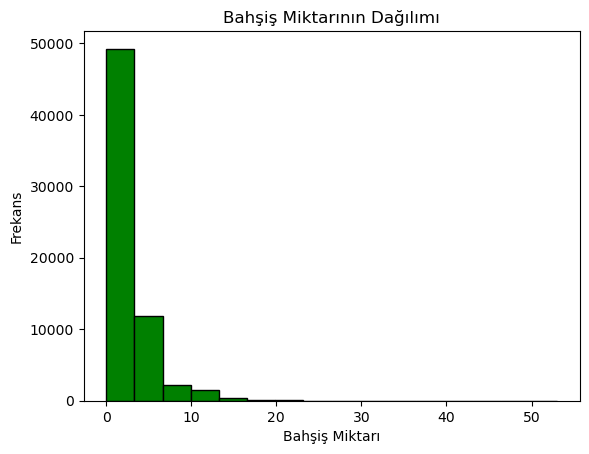

In [22]:
# Bahşiş dağılımını göster
plt.hist(clean_data.tip_amount.values, bins=16, color='g', edgecolor='black')  # Bahşiş miktarlarını 16 kutuya ayırarak histogram oluştur
plt.title('Bahşiş Miktarının Dağılımı')  # Grafiğin başlığını ayarla
plt.xlabel('Bahşiş Miktarı')  # X ekseninin etiketini ayarla
plt.ylabel('Frekans')  # Y ekseninin etiketini ayarla
plt.show()  # Grafiği göster

# 3.Veri Ön İşleme

## 3.1. Tarih Alanlarını Dönüştürme

In [29]:
# Tarih alanlarını dönüştür
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime']) 
# 'tpep_dropoff_datetime' sütununu datetime formatına çevir
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime']) 
# 'tpep_pickup_datetime' sütununu datetime formatına çevir


## 3.2. Yeni Özelliklerin Oluşturulması

In [30]:
# Pickup ve dropoff saatlerini çıkar
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Pickup ve dropoff günlerini çıkar
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Seyahat süresini dakika cinsinden hesapla
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds() / 60


## 3.3. Ön İşlenmiş Verinin Boyutunu Ayarlama

In [31]:
# Ön işlenmiş verinin boyutunu ayarla
clean_data = clean_data.head(100000)

# Tarih alanlarını çıkar
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)


## 3.4. Kategorik Özelliklerin Dönüştürülmesi

In [32]:
# Kategorik özellikleri one-hot encoding ile dönüştür
get_dummy_col = ["VendorID", "RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID", "payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]  # One-hot encoding uygulanacak kategorik sütunları tanımla
proc_data = pd.get_dummies(clean_data, columns=get_dummy_col)  # Belirtilen sütunlar için one-hot encoding uygula

# Bellek temizliği
del clean_data  # Geçici clean_data değişkenini sil
gc.collect()  # Belleği temizle


790

# 4.Hedef Değişken ve Özelliklerin Ayrılması

In [33]:
# Hedef değişken ve özellik matrisini ayır
y = proc_data[['tip_amount']].values.astype('float32')  # Hedef değişken olan 'tip_amount' sütununu al ve float32 formatına çevir
proc_data = proc_data.drop(['tip_amount'], axis=1)  # Hedef değişkeni özellik matrisinden çıkar
X = proc_data.values  # Kalan özellikleri özellik matrisine ata

# Özellik matrisini normalize et
X = normalize(X, axis=1, norm='l1')  # Özellik matrisini L1 normu kullanarak normalize et

# Özellik ve etiket matrisinin boyutunu göster
print('X.shape=', X.shape, 'y.shape=', y.shape)  # Özellik ve etiket matrisinin boyutlarını yazdır


X.shape= (65349, 460) y.shape= (65349, 1)


# 5.Eğitim/Test Verisi Bölme

In [34]:
# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'y_test.shape=', y_test.shape)


X_train.shape= (45744, 460) y_train.shape= (45744, 1)
X_test.shape= (19605, 460) y_test.shape= (19605, 1)


# 6.Model Oluşturma ve Eğitme

## 6.1. Scikit-Learn ile Karar Ağaçları Modeli

In [35]:
from sklearn.tree import DecisionTreeRegressor  # Karar ağaçları regresyon modelini sklearn kütüphanesinden içe aktar

# Karar ağaçları modelini tanımla ve eğit
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)  # Maksimum derinliği 8 olan karar ağacı modelini oluştur
t0 = time.time()  # Eğitim süresini ölçmek için başlangıç zamanını al
sklearn_dt.fit(X_train, y_train)  # Modeli eğitim verisi ile eğit
sklearn_time = time.time() - t0  # Eğitim süresini hesapla
print("[Scikit-Learn] Eğitim süresi (s): {0:.5f}".format(sklearn_time))  # Eğitim süresini yazdır


[Scikit-Learn] Eğitim süresi (s): 2.93407


## 6.2. Snap ML ile Karar Ağaçları Modeli

In [36]:
from snapml import DecisionTreeRegressor  # Snap ML kütüphanesinden karar ağaçları regresyon modelini içe aktar

# Snap ML karar ağaçları modelini tanımla ve eğit
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)  # Maksimum derinliği 8 olan karar ağacı modelini oluştur, 4 CPU iş parçacığı kullan
t0 = time.time()  # Eğitim süresini ölçmek için başlangıç zamanını al
snapml_dt.fit(X_train, y_train)  # Modeli eğitim verisi ile eğit
snapml_time = time.time() - t0  # Eğitim süresini hesapla
print("[Snap ML] Eğitim süresi (s): {0:.5f}".format(snapml_time))  # Eğitim süresini yazdır


[Snap ML] Eğitim süresi (s): 0.81889


# 7.Modellerin Değerlendirilmesi

## 7.1. Eğitim Sürelerinin Karşılaştırılması

In [37]:
# Eğitim sürelerini karşılaştır
training_speedup = sklearn_time / snapml_time
print('[Karar Ağaçları Regresyonu] Snap ML vs. Scikit-Learn hızlanması: {0:.2f}x'.format(training_speedup))


[Karar Ağaçları Regresyonu] Snap ML vs. Scikit-Learn hızlanması: 3.58x


## 7.2. MSE Hesaplama

In [39]:
# Scikit-Learn modeli ile tahmin yap ve MSE hesapla
sklearn_pred = sklearn_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE skoru: {0:.3f}'.format(sklearn_mse))

# Snap ML modeli ile tahmin yap ve MSE hesapla
snapml_pred = snapml_dt.predict(X_test)
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE skoru: {0:.3f}'.format(snapml_mse))


[Scikit-Learn] MSE skoru: 1.621
[Snap ML] MSE skoru: 1.694
